In [1]:
import calendar 
import datetime
import dask.dataframe as dd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import SVG, display

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time
# set data file path
data_file_name = '../data/crimes-2017.snappy.parq'
print('Loading data file: {}'.format(data_file_name))

# load crimes parquet data into dask df
crimes = dd.read_parquet(data_file_name, index='Date')

# load all data into memory
crimes.persist()
print('Crime data loaded into memory.')

Loading data file: ../data/crimes-2017.snappy.parq
Crime data loaded into memory.
Wall time: 2.79 s


In [4]:
%%time
# log records count and load data partitions
print('Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Crime data stats:
---------------------------------------
146,711 total records in 1 partitions
DataFrame size: 1,320,399
Wall time: 407 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
npartitions=1,,,,,,,,,
2017-01-01 00:00:00,object,object,object,object,float64,bool,bool,float64,float64
2017-07-25 23:50:00,...,...,...,...,...,...,...,...,...


In [6]:
# preview crimes data with Date index
crimes.head()

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,,
2017-07-22 04:39:00,082XX S EMERALD AVE,HOMICIDE,FIRST DEGREE MURDER,STREET,71.0,False,False,NaN,NaN
2017-07-25 22:32:00,078XX S CARPENTER ST,HOMICIDE,FIRST DEGREE MURDER,STREET,71.0,False,False,41.751545,-87.650128
2017-07-25 06:25:00,003XX N LOREL AVE,HOMICIDE,FIRST DEGREE MURDER,ALLEY,25.0,False,False,41.886330,-87.758956
2017-02-15 11:20:00,003XX S CANAL ST,HOMICIDE,FIRST DEGREE MURDER,STREET,28.0,True,False,NaN,NaN
2017-07-14 09:00:00,014XX W 112TH PL,BURGLARY,FORCIBLE ENTRY,VACANT LOT/LAND,75.0,False,False,NaN,NaN


In [7]:
# get crime types
crime_types = crimes[['PrimaryType']]
crime_types.head()

,PrimaryType
Date,
2017-07-22 04:39:00,HOMICIDE
2017-07-25 22:32:00,HOMICIDE
2017-07-25 06:25:00,HOMICIDE
2017-02-15 11:20:00,HOMICIDE
2017-07-14 09:00:00,BURGLARY


In [8]:
# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# print crime stats
print(crime_type_total.sort_values(ascending=False))
print("...\nTotal Primary Crime Types: {:,}".format(crime_type_total.size))

PrimaryType
THEFT                                34103
BATTERY                              27828
CRIMINAL DAMAGE                      16362
ASSAULT                              10925
OTHER OFFENSE                        10047
DECEPTIVE PRACTICE                    9455
BURGLARY                              7190
MOTOR VEHICLE THEFT                   6355
ROBBERY                               6207
NARCOTICS                             5890
CRIMINAL TRESPASS                     3939
WEAPONS VIOLATION                     2616
OFFENSE INVOLVING CHILDREN            1194
PUBLIC PEACE VIOLATION                 877
CRIM SEXUAL ASSAULT                    808
INTERFERENCE WITH PUBLIC OFFICER       633
SEX OFFENSE                            514
PROSTITUTION                           488
HOMICIDE                               387
ARSON                                  266
LIQUOR LAW VIOLATION                   122
STALKING                               118
KIDNAPPING                             105

In [9]:
# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']].groupby('PrimaryType').sum().compute()

# print arrests stats
print(crime_type_counts.sort_values(by='Arrest', ascending=False))

                                   Arrest  Domestic
PrimaryType                                        
NARCOTICS                          5887.0       5.0
BATTERY                            5533.0   13553.0
THEFT                              3459.0    1306.0
CRIMINAL TRESPASS                  2391.0     184.0
OTHER OFFENSE                      2247.0    3110.0
WEAPONS VIOLATION                  2093.0      10.0
ASSAULT                            1936.0    2801.0
CRIMINAL DAMAGE                     974.0    1898.0
INTERFERENCE WITH PUBLIC OFFICER    601.0       3.0
PUBLIC PEACE VIOLATION              587.0      29.0
MOTOR VEHICLE THEFT                 510.0      61.0
PROSTITUTION                        488.0       0.0
ROBBERY                             378.0     110.0
DECEPTIVE PRACTICE                  350.0      87.0
BURGLARY                            251.0     100.0
OFFENSE INVOLVING CHILDREN          144.0     599.0
LIQUOR LAW VIOLATION                122.0       1.0
GAMBLING    

In [10]:
# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic + total)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic  Total
PrimaryType                                               
THEFT                              3459.0    1306.0  34103
BATTERY                            5533.0   13553.0  27828
CRIMINAL DAMAGE                     974.0    1898.0  16362
ASSAULT                            1936.0    2801.0  10925
OTHER OFFENSE                      2247.0    3110.0  10047
DECEPTIVE PRACTICE                  350.0      87.0   9455
BURGLARY                            251.0     100.0   7190
MOTOR VEHICLE THEFT                 510.0      61.0   6355
ROBBERY                             378.0     110.0   6207
NARCOTICS                          5887.0       5.0   5890
CRIMINAL TRESPASS                  2391.0     184.0   3939
WEAPONS VIOLATION                  2093.0      10.0   2616
OFFENSE INVOLVING CHILDREN          144.0     599.0   1194
PUBLIC PEACE VIOLATION              587.0      29.0    877
CRIM SEXUAL ASSAULT                  30.0     117.0    8

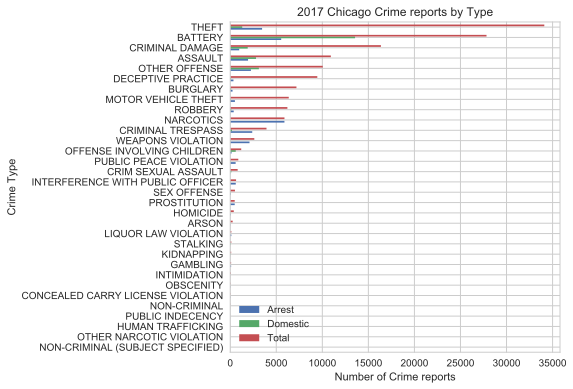

In [11]:
# plot crimes by primary type counts
plt.figure(figsize=(8,10))
crime_type_counts.sort_values(by='Total', ascending=True).plot(kind='barh')

plt.title('2017 Chicago Crime reports by Type')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crime reports')
plt.tight_layout()
plt.show()

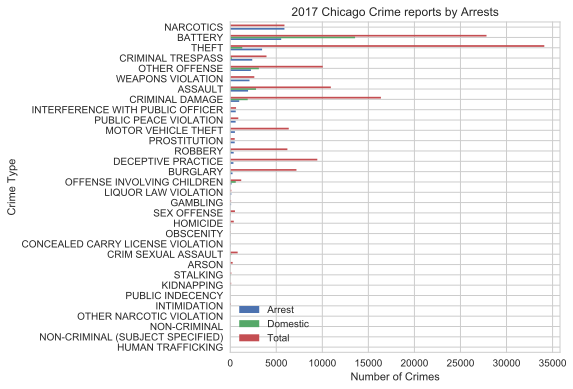

In [12]:
# plot crimes by arrests
crime_type_counts.sort_values(by='Arrest', ascending=True).plot(kind='barh')

plt.title('2017 Chicago Crime reports by Arrests')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

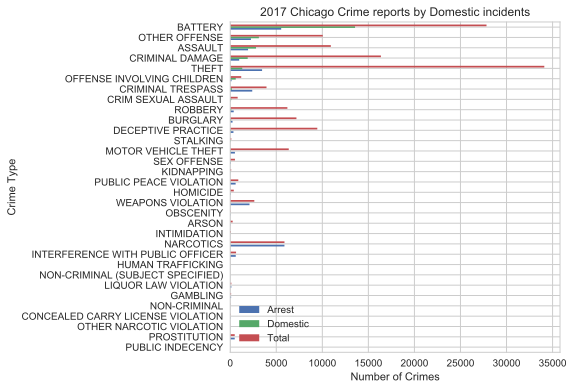

In [13]:
# plot crimes by domestic incident reports
crime_type_counts.sort_values(by='Domestic', ascending=True).plot(kind='barh')

plt.title('2017 Chicago Crime reports by Domestic incidents')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

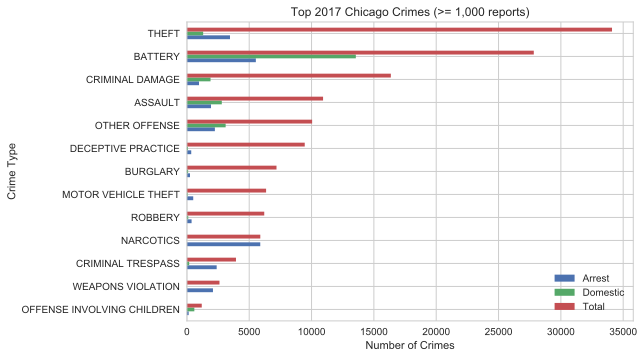

In [14]:
# plot top crimes (>-= 1,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 1000].sort_values(by='Total', ascending=True)\
.plot(kind='barh')

plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Top 2017 Chicago Crimes (>= 1,000 reports)')

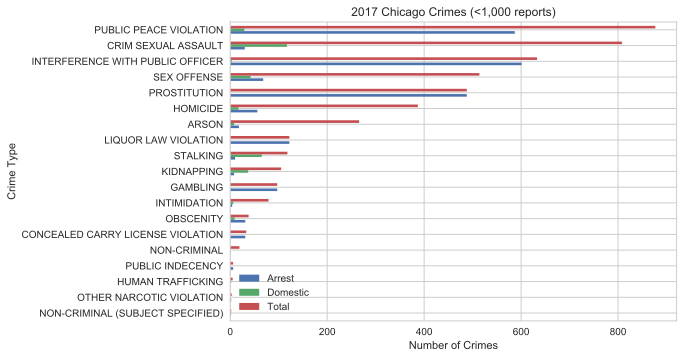

In [15]:
# plot less than 1000 crime reports types
crime_type_counts[crime_type_counts['Total'] < 1000].sort_values(by='Total', ascending=True)\
.plot(kind='barh')

plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crimes (<1,000 reports)')

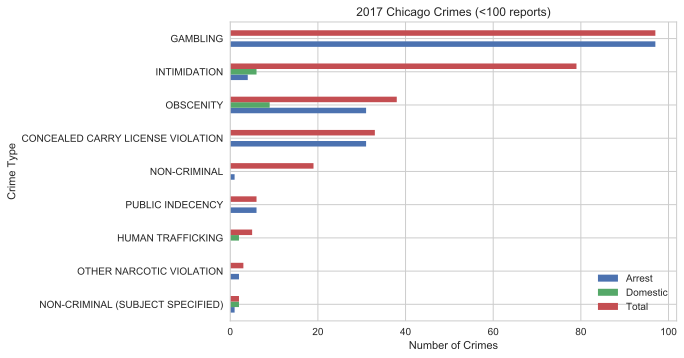

In [16]:
# plot less than 100 crime reports types
crime_type_counts[crime_type_counts['Total'] < 100].sort_values(by='Total', ascending=True)\
.plot(kind='barh')

plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crimes (<100 reports)')

In [17]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       33216
RESIDENCE    25197
APARTMENT    18650
SIDEWALK     11466
OTHER         6024
Name: Total, dtype: int64
...
Total Locations: 121


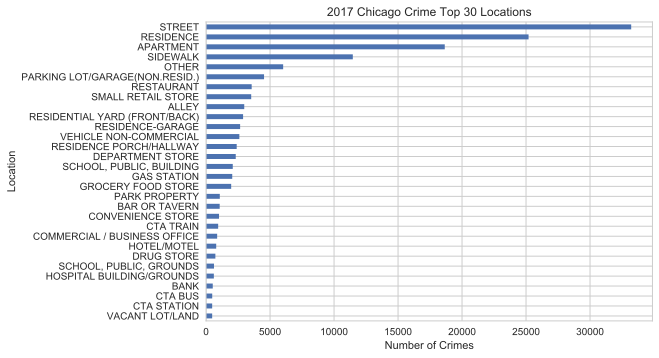

In [18]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top 30 Locations')

In [19]:
# get arrests and domestic counts for each location description
crime_location_counts = crimes[['LocationDescription', 'Arrest', 'Domestic']]\
.groupby('LocationDescription').sum().compute()

# add crime location totals column
crime_location_counts['Total'] = crime_locations
crime_location_counts.head()

,Arrest,Domestic,Total
LocationDescription,,,
ABANDONED BUILDING,85.0,7.0,196
AIRCRAFT,2.0,0.0,33
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,7.0,1.0,53
AIRPORT BUILDING NON-TERMINAL - SECURE AREA,4.0,2.0,41
AIRPORT EXTERIOR - NON-SECURE AREA,6.0,1.0,48


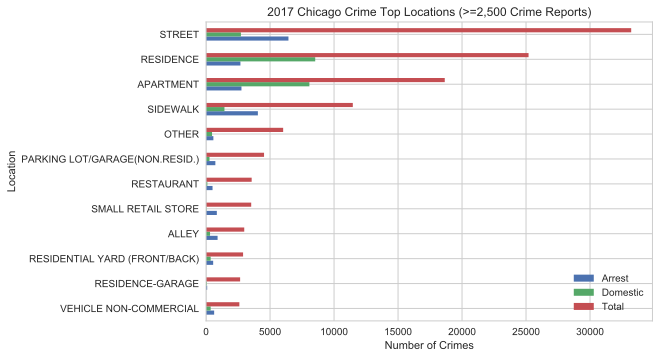

In [20]:
# plot top crime locations with arrests and domestic crime counts
crime_location_counts[crime_location_counts['Total'] >= 2500]\
.sort_values(by='Total', ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top Locations (>=2,500 Crime Reports)')

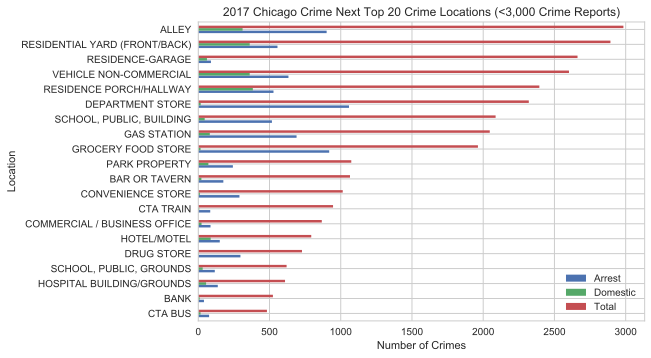

In [21]:
# plot next 20 top crime locations
crime_location_counts = crime_location_counts[crime_location_counts['Total'] <= 3000]\
.sort_values(by='Total', ascending=False)
crime_location_counts[:20].sort_values(by='Total', ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Next Top 20 Crime Locations (<3,000 Crime Reports)')

In [22]:
# check for datetime64 index to plot crime over time
crimes.index

Dask Index Structure:
npartitions=1
2017-01-01 00:00:00    datetime64[ns]
2017-07-25 23:50:00               ...
Name: Date, dtype: datetime64[ns]
Dask Name: read-parquet, 2 tasks

In [23]:
# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

Date
2017-02-15 11:20:00    True
2017-07-25 18:30:00    True
2017-07-25 23:00:00    True
2017-07-25 15:15:00    True
2017-07-25 11:40:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 28,314


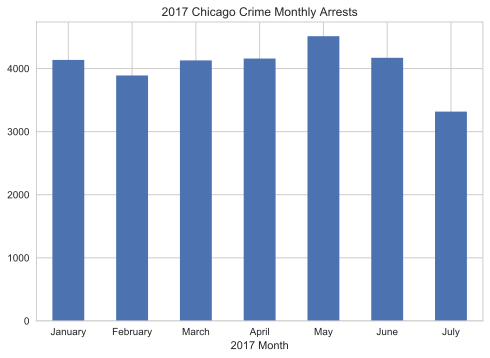

In [24]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(kind='bar')

plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.xlabel('2017 Month')
plt.title('2017 Chicago Crime Monthly Arrests')
plt.show()

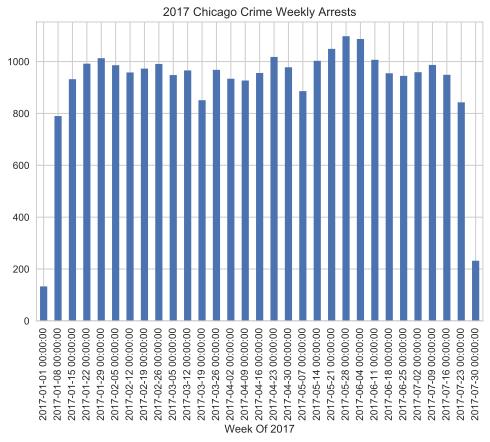

In [25]:
# plot weekly arrests
weekly_arrests = arrests.resample('W').sum().compute()
weekly_arrests.plot(kind='bar')

# TODO: format weekly xticks to only list week start date
plt.xlabel('Week Of 2017')
plt.title('2017 Chicago Crime Weekly Arrests')
plt.show()

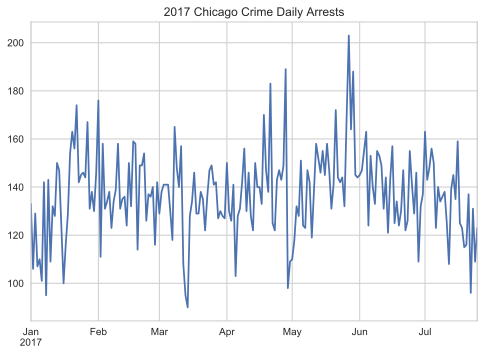

In [26]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('2017 Chicago Crime Daily Arrests')
plt.show()

In [27]:
# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))

Date
2017-07-22 08:30:00    True
2017-07-02 18:00:00    True
2017-07-15 02:00:00    True
2017-07-02 11:45:00    True
2017-07-23 13:00:00    True
Name: Domestic, dtype: bool
...
Total Domestic: 24,162


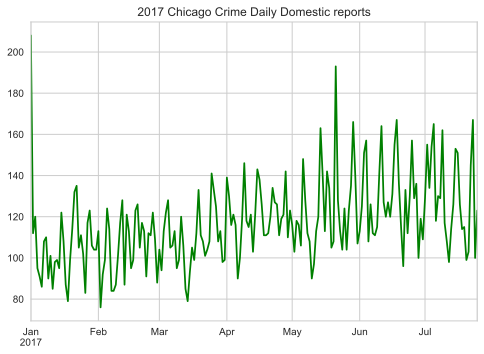

In [28]:
# plot daily domestic crimes
daily_domestic = domestic.resample('D').sum().compute()
daily_domestic.plot(color='g')
plt.title('2017 Chicago Crime Daily Domestic reports')
plt.show()

In [29]:
# get daily total crime counts
daily_crime = crime_types.resample('D').count().compute()

#print daily total crime stats
print(daily_crime.head())
print("...\nTotal Days: {:,}".format(daily_crime.size))

            PrimaryType
2017-01-01          920
2017-01-02          598
2017-01-03          704
2017-01-04          610
2017-01-05          599
...
Total Days: 206


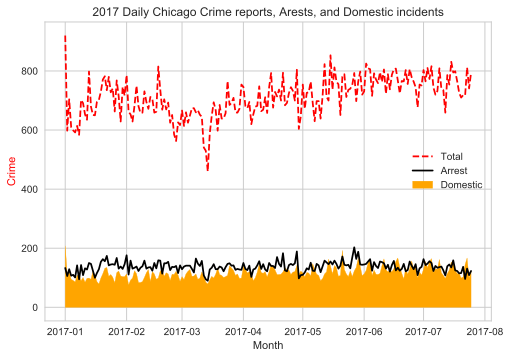

In [30]:
# plot daily crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, '--', label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='black', zorder=10)
ax.fill_between(daily_domestic.index, daily_domestic, label='Domestic', color='orange')

ax.set_ylabel('Crime', color='r')
ax.set_xlabel('Month')
ax.legend(loc='right')
plt.title('2017 Daily Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [31]:
# get the most violent underreported crimes, in my opinion
violent_crimes = crime_types[(crime_types['PrimaryType']=='ARSON') | \
                             (crime_types['PrimaryType']=='CRIM SEXUAL ASSAULT') | \
                             (crime_types['PrimaryType']=='HOMICIDE') | \
                             (crime_types['PrimaryType']=='HUMAN TRAFFICKING') | \
                             (crime_types['PrimaryType']=='KIDNAPPING') | \
                             (crime_types['PrimaryType']=='OFFENSE INVOLVING CHILDREN')]

# print violent crimes stats
print(violent_crimes.head(10))
print('...............................................')
print(violent_crimes.PrimaryType.value_counts().head(6))

                                    PrimaryType
Date                                           
2017-07-22 04:39:00                    HOMICIDE
2017-07-25 22:32:00                    HOMICIDE
2017-07-25 06:25:00                    HOMICIDE
2017-02-15 11:20:00                    HOMICIDE
2017-07-24 04:25:00                       ARSON
2017-07-15 02:00:00         CRIM SEXUAL ASSAULT
2017-02-01 08:00:00         CRIM SEXUAL ASSAULT
2017-07-25 02:00:00         CRIM SEXUAL ASSAULT
2017-03-24 19:00:00  OFFENSE INVOLVING CHILDREN
2017-02-16 02:00:00         CRIM SEXUAL ASSAULT
...............................................
OFFENSE INVOLVING CHILDREN    1194
CRIM SEXUAL ASSAULT            808
HOMICIDE                       387
ARSON                          266
KIDNAPPING                     105
HUMAN TRAFFICKING                5
Name: PrimaryType, dtype: int64


In [32]:
# categorize by primary type
violent_crimes = violent_crimes.categorize(columns='PrimaryType')
print(violent_crimes)

# print selected violent crimes primary type categories
print('\nSelected Primary Type categories:')
print('----------------------------------------------------------------------')
print(violent_crimes.PrimaryType.cat.categories)

Dask DataFrame Structure:
                         PrimaryType
npartitions=1                       
2017-01-01 00:00:00  category[known]
2017-07-25 23:50:00              ...
Dask Name: _categorize_block, 16 tasks

Selected Primary Type categories:
----------------------------------------------------------------------
Index(['HOMICIDE', 'ARSON', 'CRIM SEXUAL ASSAULT',
       'OFFENSE INVOLVING CHILDREN', 'KIDNAPPING', 'HUMAN TRAFFICKING'],
      dtype='object', name='PrimaryType')


In [33]:
# group violent crimes by month and crime type
violent_crimes_groupby = violent_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
violent_crime_data = violent_crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(violent_crime_data.head(10))
print('...')

# unstack violent crime type group for series plotting
violent_crime_data = violent_crime_data.unstack()
print(violent_crime_data.head(12))

print("...\nTotal Monthly/Type records: {:,}".format(violent_crime_data.size))

Date        PrimaryType               
2017-01-31  HOMICIDE                       53
            ARSON                          37
            CRIM SEXUAL ASSAULT           134
            OFFENSE INVOLVING CHILDREN    214
            KIDNAPPING                      8
2017-02-28  HOMICIDE                       48
            ARSON                          40
            CRIM SEXUAL ASSAULT           117
            OFFENSE INVOLVING CHILDREN    119
            KIDNAPPING                     13
Name: Count, dtype: int64
...
PrimaryType  HOMICIDE  ARSON  CRIM SEXUAL ASSAULT  OFFENSE INVOLVING CHILDREN  \
Date                                                                            
2017-01-31       53.0   37.0                134.0                       214.0   
2017-02-28       48.0   40.0                117.0                       119.0   
2017-03-31       37.0   27.0                 95.0                       175.0   
2017-04-30       46.0   46.0                130.0                 

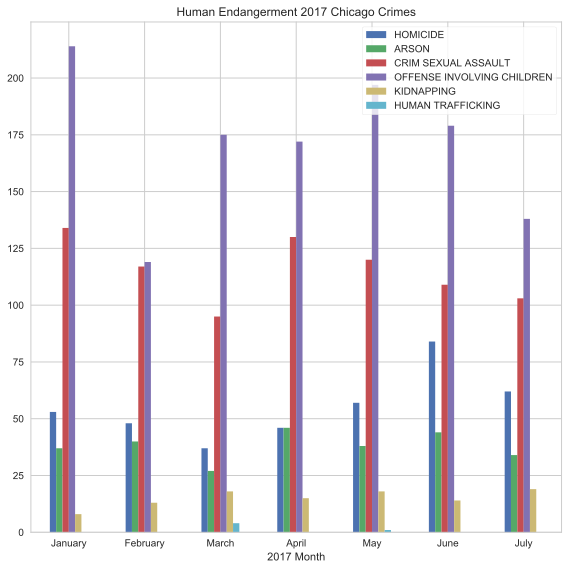

In [34]:
# plot violent crime data
violent_crime_data.plot(figsize=(8,8), kind='bar')

plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Human Endangerment 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [35]:
# get top 5 crimes
top_5_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                             (crime_types['PrimaryType']=='BATTERY') | \
                             (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                             (crime_types['PrimaryType']=='ASSAULT') | \
                             (crime_types['PrimaryType']=='OTHER OFFENSE')]
top_5_crimes.head(10)

,PrimaryType
Date,
2017-07-22 08:30:00,BATTERY
2017-07-24 12:00:00,THEFT
2017-07-10 07:00:00,THEFT
2017-07-24 00:00:00,ASSAULT
2017-07-19 15:38:00,ASSAULT
2017-07-02 11:45:00,OTHER OFFENSE
2017-06-03 08:00:00,OTHER OFFENSE
2017-07-23 13:00:00,OTHER OFFENSE
2017-07-17 11:30:00,OTHER OFFENSE


In [36]:
# print top 5 crime counts
top_5_crimes.PrimaryType.value_counts().head()

THEFT              34103
BATTERY            27828
CRIMINAL DAMAGE    16362
ASSAULT            10925
OTHER OFFENSE      10047
Name: PrimaryType, dtype: int64

In [37]:
print('Monthly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by month and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))

Monthly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-31  ASSAULT            1373
            BATTERY            3557
            CRIMINAL DAMAGE    2406
            OTHER OFFENSE      1548
            THEFT              4922
2017-02-28  ASSAULT            1294
            BATTERY            3405
            CRIMINAL DAMAGE    2043
            OTHER OFFENSE      1368
            THEFT              4365
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-31      1373     3557             2406           1548   4922
2017-02-28      1294     3405             2043           1368   4365
2017-03-31      1480     3851             2231           1506   4460
2017-04-30      1635     4093             2438           1547   4743
2017-05-31      1842     4551             2506           1604   5284
201

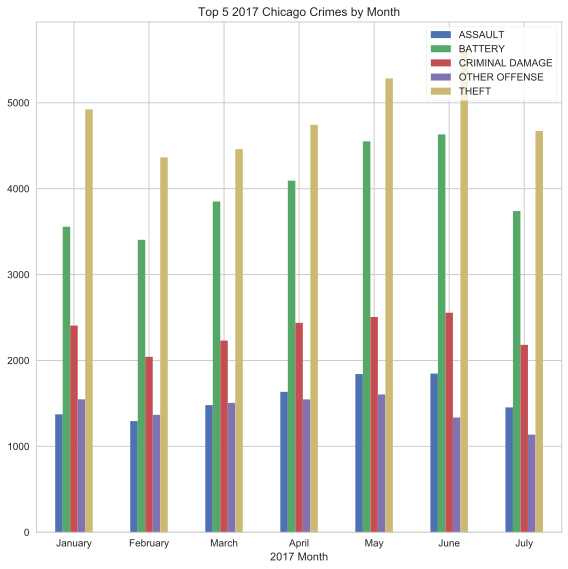

In [38]:
# plot top 5 crimes data
top_5_crime_data.plot(figsize=(8,8), kind='bar')

plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Top 5 2017 Chicago Crimes by Month')
plt.tight_layout()
plt.show()

In [39]:
print('Weekly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by week and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('W'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Weekly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  ASSAULT             45
            BATTERY            202
            CRIMINAL DAMAGE    113
            OTHER OFFENSE       69
            THEFT              177
2017-01-08  ASSAULT            300
            BATTERY            714
            CRIMINAL DAMAGE    476
            OTHER OFFENSE      335
            THEFT              907
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-01        45      202              113             69    177
2017-01-08       300      714              476            335    907
2017-01-15       292      766              524            383   1075
2017-01-22       338      815              568            349   1234
2017-01-29       312      824              569            319   1197
2017-02-05    

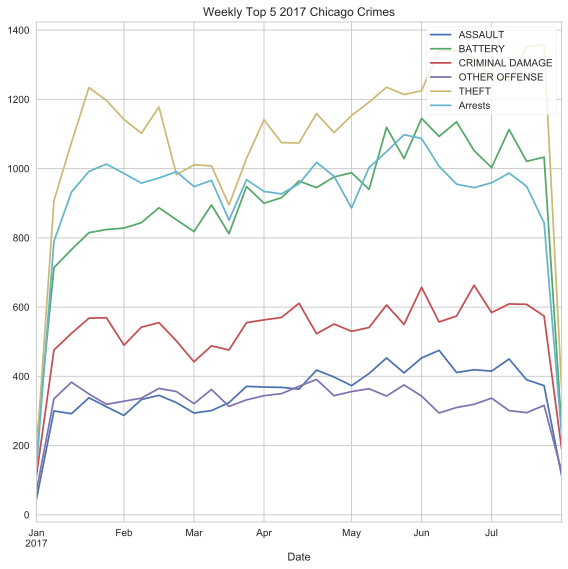

In [40]:
# add weekly arrests data for comparison of crime fighting efforts
top_5_crime_data['Arrests'] = weekly_arrests

# plot Weekly top 5 crimes data
top_5_crime_data.plot(figsize=(8,8))

#plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.title('Weekly Top 5 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [41]:
print('Daily Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by day and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('D'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Daily Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  ASSAULT             45
            BATTERY            202
            CRIMINAL DAMAGE    113
            OTHER OFFENSE       69
            THEFT              177
2017-01-02  ASSAULT             38
            BATTERY            105
            CRIMINAL DAMAGE     72
            OTHER OFFENSE       43
            THEFT              120
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  CRIMINAL DAMAGE  OTHER OFFENSE  THEFT
Date                                                                
2017-01-01        45      202              113             69    177
2017-01-02        38      105               72             43    120
2017-01-03        55      114               79             43    149
2017-01-04        34       95               57             54    161
2017-01-05        42       84               68             56    131
2017-01-06     

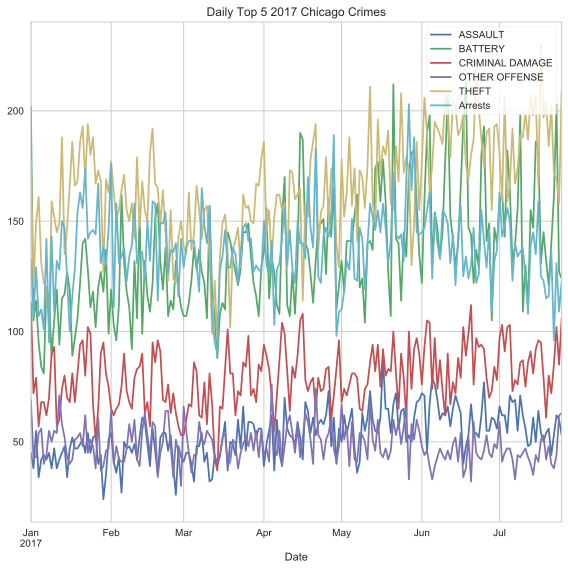

In [42]:
# add daily arrests data for comparison of crime fighting efforts
top_5_crime_data['Arrests'] = daily_arrests

# plot Daily top 5 crime data
top_5_crime_data.plot(figsize=(8,8))

#plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.title('Daily Top 5 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [43]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

,CommunityArea,CommunityName,Side
0,0,NaN,NaN
1,1,Rogers Park,Far North Side
2,2,West Ridge,Far North Side
3,3,Uptown,Far North Side
4,4,Lincoln Square,Far North Side


In [44]:
# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName       Side  Total
25             25           Austin  West Side   8643
8               8  Near North Side    Central   6198
32             32             Loop    Central   5393
28             28   Near West Side  West Side   4967
29             29   North Lawndale  West Side   4829
...
Total Communities: 77


In [45]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,8643
Near North Side,6198
Loop,5393
Near West Side,4967
North Lawndale,4829


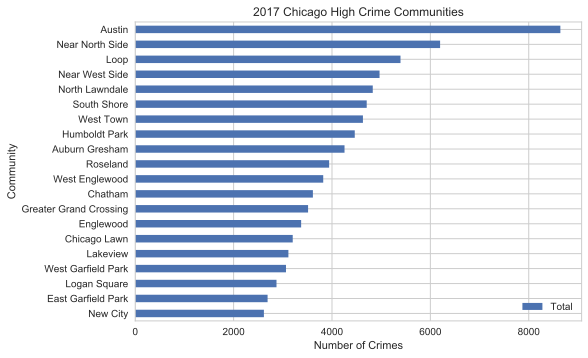

In [46]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago High Crime Communities')

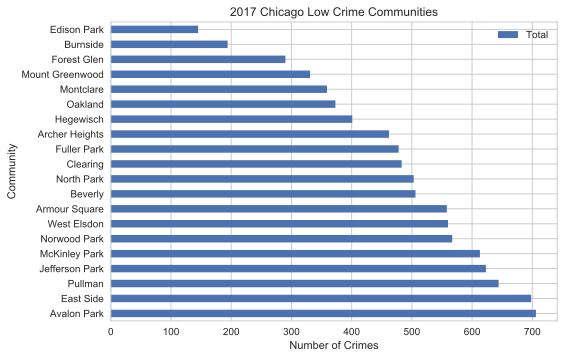

In [47]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False).plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Low Crime Communities')

In [48]:
community_areas.head()

,CommunityArea,CommunityName,Side,Total
0,0,NaN,NaN,1
1,1,Rogers Park,Far North Side,2241
2,2,West Ridge,Far North Side,1914
3,3,Uptown,Far North Side,1881
4,4,Lincoln Square,Far North Side,993


In [49]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum().drop('CommunityArea', axis=1) # denotes column
crime_by_side

,Total
Side,
Central,12635
Far North Side,12768
Far Southeast Side,17363
Far Southwest Side,9400
North Side,10380
Northwest Side,8025
South Side,19159
Southwest Side,19702
West Side,37278


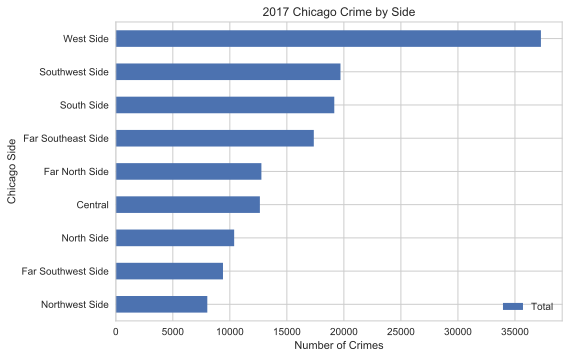

In [50]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh')
plt.ylabel('Chicago Side')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime by Side')

In [51]:
# show Chicago sides svg for reference
display(SVG(url='../data/chicago-community-areas.svg'))

<IPython.core.display.SVG object>